In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
test_dir = '/content/drive/MyDrive/archive/test'

train_dir = '/content/drive/MyDrive/archive/train'

val_dir = '/content/drive/MyDrive/archive/val'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
!unzip "/content/drive/MyDrive/images_final.zip"

In [ ]:
def prepare_df(data_type):
    X = []
    y = []
    path = '/content/drive/MyDrive/archive/' + data_type + '/'

    for i in os.listdir(path):
      # print(i)
      # Image
      X.append(i)
      # Label
      y.append((i.split('_')[1]).split('.')[0])

    X = np.array(X)
    y = np.array(y)

    df = pd.DataFrame()
    df['filename'] = X
    df['label'] = y

    return df



In [ ]:
df_train = prepare_df('train')
df_test = prepare_df('test')
df_val = prepare_df('val')

In [ ]:
df_test.head()

,filename,label
0,82_black.jpg,black
1,17_black.jpg,black
2,41_black.jpg,black
3,11_black.jpg,black
4,75_black.jpg,black


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=[0.8,1.0],
    # channel_shift_range=30,
    # horizontal_flip=True,
)




# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory='/content/drive/MyDrive/archive/train/',
    x_col='filename',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
df_test,
directory="/content/drive/MyDrive/archive/test/",
x_col="filename",
y_col="label",
color_mode='rgb',
batch_size=32,
seed=42,
shuffle=False,
class_mode='categorical',
target_size=(224,224))

val_datagen=ImageDataGenerator(rescale=1./255.)

val_generator=val_datagen.flow_from_dataframe(
df_test,
directory="/content/drive/MyDrive/archive/val/",
x_col="filename",
y_col="label",
color_mode='rgb',
batch_size=32,
seed=42,
shuffle=False,
class_mode='categorical',
target_size=(224,224))

Found 4652 validated image filenames belonging to 9 classes.
Found 996 validated image filenames belonging to 9 classes.
Found 992 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
x,y = next(train_generator)
x.shape

(32, 224, 224, 3)

In [ ]:
import matplotlib.pyplot as plt
def plot_images(img):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.axis('off')

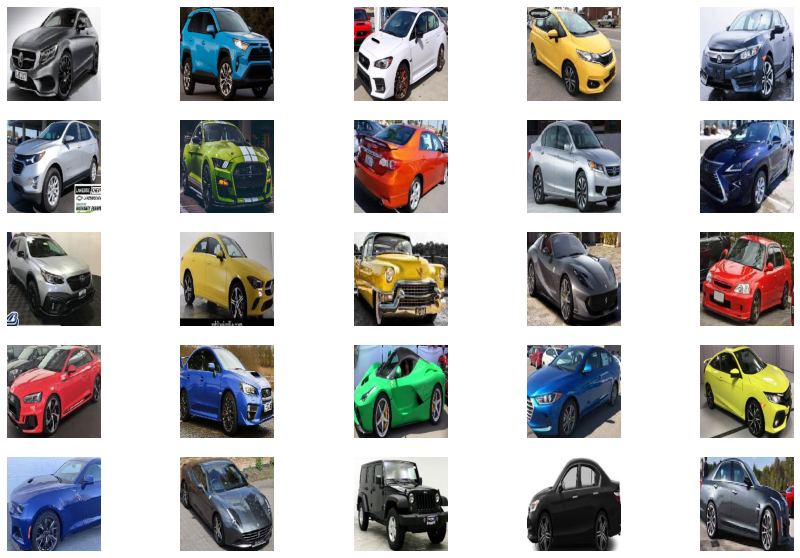

In [ ]:
plot_images(x)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', 
                             input_shape=(224, 224, 3),
                             include_top=False)
base_model.trainable = True
model = tf.keras.Sequential([
        data_augmentation,
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(9, activation='softmax')
    ])

# model = tf.keras.Sequential([
#         data_augmentation,
#         base_model,          
#         tf.keras.layers.GlobalAveragePooling2D(),
#         # tf.keras.layers.Dropout(0.5),
#         # tf.keras.layers.Dense(1024, activation='relu'),
#         # tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(6, activation='softmax')
#     ])

opt = tf.keras.optimizers.Adam(0.0001)
# Compile it
model.compile(optimizer=opt,
             loss='CategoricalCrossentropy',
             metrics=['categorical_accuracy'])

# Print The Summary of The Model
model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 batch_normalization_94 (Bat  (None, 5, 5, 2048)       14336     
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                       

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=5,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL = val_generator.n//val_generator.batch_size
# fit model
model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=val_generator,
          validation_steps=STEP_SIZE_VAL,
          epochs=10)

Epoch 1/10
145/145 [==============================] - 1857s 13s/step - loss: 1.2103 - categorical_accuracy: 0.5623 - val_loss: 0.8401 - val_categorical_accuracy: 0.7389
Epoch 2/10
145/145 [==============================] - 44s 302ms/step - loss: 0.5330 - categorical_accuracy: 0.8251 - val_loss: 0.4552 - val_categorical_accuracy: 0.8589
Epoch 3/10
145/145 [==============================] - 44s 303ms/step - loss: 0.4052 - categorical_accuracy: 0.8684 - val_loss: 0.4548 - val_categorical_accuracy: 0.8417
Epoch 4/10
145/145 [==============================] - 44s 301ms/step - loss: 0.3475 - categorical_accuracy: 0.8890 - val_loss: 0.3204 - val_categorical_accuracy: 0.8881
Epoch 5/10
145/145 [==============================] - 44s 305ms/step - loss: 0.2677 - categorical_accuracy: 0.9143 - val_loss: 0.2912 - val_categorical_accuracy: 0.9083
Epoch 6/10
145/145 [==============================] - 44s 304ms/step - loss: 0.2447 - categorical_accuracy: 0.9206 - val_loss: 0.4021 - val_categorical_acc

In [ ]:
accuracy_score = model.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

32/32 [==============================] - 317s 10s/step - loss: 0.3588 - categorical_accuracy: 0.8845
[0.35877153277397156, 0.8845381736755371]
Accuracy: 88.4538%
Loss:  0.35877153277397156


In [ ]:
classes=test_generator.class_indices.keys()

In [ ]:
labels=test_generator.labels

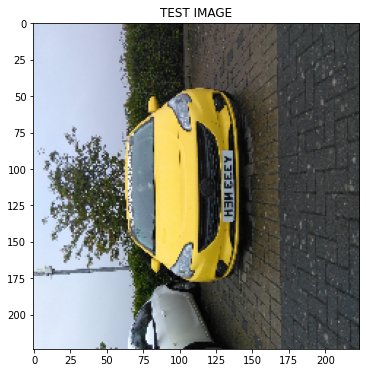

In [ ]:
from google.colab.patches import cv2_imshow

import cv2
test_img_path = '/content/drive/MyDrive/c1.jpg'
 
img = cv2.imread(test_img_path)


# resized_img2 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img_rgb, (224, 224)).reshape(1,224, 224, 3)/255
# cv2_imshow(img_rgb )
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(test_img[0])

In [ ]:
np.shape(resized_img)

(1, 224, 224, 3)

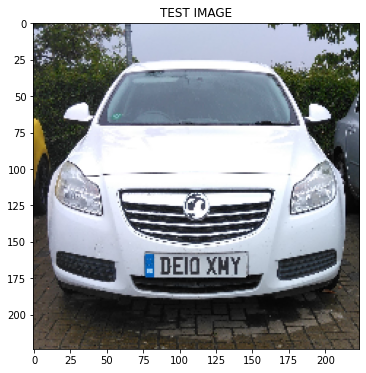

In [ ]:
from google.colab.patches import cv2_imshow

test_img_path = '/content/drive/MyDrive/c2.jpg'
 
img = cv2.imread(test_img_path)


# resized_img2 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img_rgb, (224, 224)).reshape(-1, 224, 224, 3)/255
# cv2_imshow(img_rgb )
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

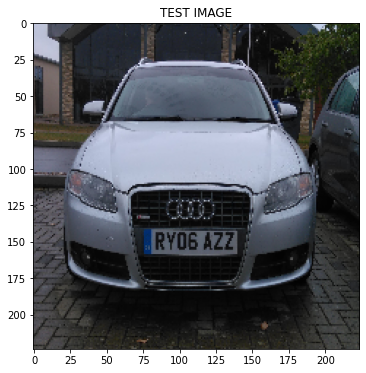

In [ ]:
from google.colab.patches import cv2_imshow

test_img_path = '/content/drive/MyDrive/c3.jpg'
 
img = cv2.imread(test_img_path)


# resized_img2 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img_rgb, (224, 224)).reshape(-1, 224, 224, 3)/255
# cv2_imshow(img_rgb )
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

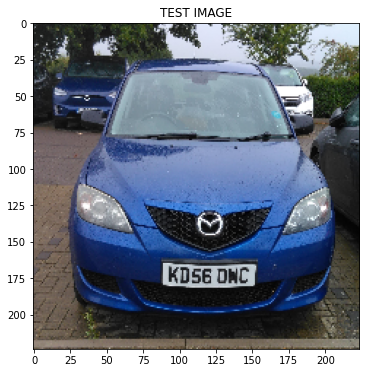

In [ ]:
from google.colab.patches import cv2_imshow

test_img_path = '/content/drive/MyDrive/c4.jpg'
 
img = cv2.imread(test_img_path)


# resized_img2 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img_rgb, (224, 224)).reshape(-1, 224, 224, 3)/255
# cv2_imshow(img_rgb )
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

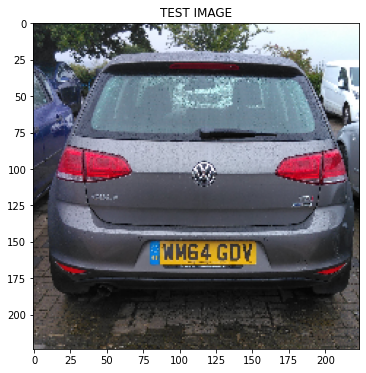

In [ ]:
from google.colab.patches import cv2_imshow

test_img_path = '/content/drive/MyDrive/c5.jpg'
 
img = cv2.imread(test_img_path)


# resized_img2 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img_rgb, (224, 224)).reshape(-1, 224, 224, 3)/255
# cv2_imshow(img_rgb )
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [ ]:
from google.colab.patches import cv2_imshow

test_img_path = '/content/drive/MyDrive/c6.jpg'
 
img = cv2.imread(test_img_path)


# resized_img2 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img_rgb, (224, 224)).reshape(-1, 224, 224, 3)/255
# cv2_imshow(img_rgb )
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

NameError: ignored

In [ ]:
ans = model.predict(resized_img)
# ans = mod.predict(img)
# ans1 = model.predict(resized_img1)
# ans2 = model.predict(resized_img2)

In [ ]:
mod = tf.keras.models.load_model('test_color.h5')

In [ ]:
output = tf.nn.softmax(ans[0])
print(classes)
print(np.argmax(output))

dict_keys(['black', 'blue', 'green', 'grey', 'orange', 'red', 'silver', 'white', 'yellow'])
8


In [ ]:
print(output)

tf.Tensor([0.12957112 0.12957372 0.12957232 0.12959252 0.12958333 0.352107  ], shape=(6,), dtype=float32)


In [ ]:
print(ans[0])

In [ ]:
output1 = tf.nn.softmax(ans1[0])
print(classes)
print(np.argmax(output1))

dict_keys(['Audi', 'BMW', 'Citroen', 'Mazda', 'Peugeot', 'VW'])
5


In [ ]:
output2 = tf.nn.softmax(ans2[0])
print(classes)
print(np.argmax(output2))

dict_keys(['Audi', 'BMW', 'Citroen', 'Mazda', 'Peugeot', 'VW'])
4


In [ ]:
model.save('test_color.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/test_color.h5')

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.post_training_quantize=True
tflite_model = converter.convert()


# Save the model.
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import tensorflow as tf


# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'serving_default_sequential_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 329, 'shape': array([1, 9], dtype=int32), 'shape_signature': array([-1,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
pip install tflite-support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.2 MB 2.4 MB/s 
     |████████████████████████████████| 1.0 MB 48.3 MB/s 
     |████████████████████████████████| 213 kB 5.5 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


In [ ]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Custom Car Colour classifier"
model_meta.description = ("Identify the most prominent colour in the "
                          "image from a set of 9 colours such as "
                          "red, black, silver, yellow etc.")
model_meta.version = "v1"
model_meta.author = "Tapan Auti"
model_meta.license = ("Chipside Restricted Licence")

In [ ]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [ ]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 1.".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [0]
input_normalization.options.std = [255]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [ ]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 9 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("/content/drive/MyDrive/label.txt")
label_file.description = "Labels for Colours that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [ ]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [ ]:
model_path = "/content/drive/MyDrive/model.tflite"
populator = _metadata.MetadataPopulator.with_model_file(model_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["/content/drive/MyDrive/label.txt"])
populator.populate()